In [27]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [28]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


In [29]:
img_path_list = []
Top_change_imp_VS_path = './data/box_img/Top_change_VS_imp/'

for i in range(1, 33):
    for j in range(1, 5):
        if i == 9 and j == 1: 
            continue
        img_path_list.append('./data/test_img/AI-{}_0{}_transformed.jpg'.format(i, j))

전처리한 이미지 RGB / HSV

In [30]:
top_avg_bgr = []
top_avg_hsv = []

for i in range(len(img_path_list)):
    # 이미지 로드
    img = cv2.cvtColor(np.array(Image.open(Top_change_imp_VS_path + 'Top_change_VS_{}.jpg'.format(i))), cv2.COLOR_RGB2BGR)
    # RGB 평균 계산
    avg_bgr = img.mean(axis=(0,1))
    top_avg_bgr.append(avg_bgr)
    # HSV 평균 계산
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    avg_hsv = img_hsv.mean(axis=(0,1))
    top_avg_hsv.append(avg_hsv)

In [31]:
Table_dataset = pd.DataFrame({'Top_R' : [i[2] for i in top_avg_bgr], 
                              'Top_G' : [i[1] for i in top_avg_bgr], 
                              'Top_B' : [i[0] for i in top_avg_bgr],
                              'Top_H' : [i[0] for i in top_avg_hsv], 
                              'Top_S' : [i[1] for i in top_avg_hsv], 
                              'Top_V' : [i[2] for i in top_avg_hsv],
                              'Thickness': Thickness['Thickness']})

Table_dataset

,Top_R,Top_G,Top_B,Top_H,Top_S,Top_V,Thickness
0,11.5752,10.8824,8.0332,22.1580,79.0864,11.5752,48.266667
1,10.2804,10.4340,9.0232,23.5584,41.5664,10.5508,47.966667
2,10.0228,9.9236,7.9204,29.0352,56.4348,10.0308,48.166667
3,8.3744,8.5136,6.1348,26.7236,77.8136,8.6560,48.600000
4,4.1716,2.2884,1.1488,27.9292,211.7900,4.3000,59.533333
...,...,...,...,...,...,...,...
122,1.8884,5.0128,18.5152,114.3780,229.4796,18.5152,84.633333
123,6.9784,15.3760,26.5632,106.8272,188.4016,26.5632,98.366667
124,3.3400,13.3692,33.3720,109.8596,230.0004,33.3720,97.033333
125,5.8372,15.0308,31.7036,109.2272,208.5904,31.7036,96.266667


In [32]:
Table_dataset.describe()

,Top_R,Top_G,Top_B,Top_H,Top_S,Top_V,Thickness
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,23.225235,11.996866,17.401515,93.470142,189.899143,35.035219,84.826509
std,55.003025,17.743753,12.271615,39.412123,57.017190,54.494905,20.421769
min,0.304800,0.230000,0.175600,6.156400,4.168400,0.732000,47.966667
25%,1.887800,2.165000,6.674400,80.113000,158.049000,8.040200,72.966667
50%,4.587200,7.644800,15.778400,107.046400,207.634800,20.946000,82.166667
75%,13.153000,17.363400,27.700400,114.470800,236.964400,32.938000,96.600000
max,250.224800,167.329200,41.627600,177.105600,253.127600,250.224800,161.100000


안쓸피쳐드랍

In [9]:
Table_dataset = Table_dataset.drop(['Top_R', 'Top_G', 'Top_B'], axis=1)
Table_dataset

,Top_H,Top_S,Top_V,Thickness
0,22.1580,79.0864,11.5752,48.266667
1,23.5584,41.5664,10.5508,47.966667
2,29.0352,56.4348,10.0308,48.166667
3,26.7236,77.8136,8.6560,48.600000
4,27.9292,211.7900,4.3000,59.533333
...,...,...,...,...
122,114.3780,229.4796,18.5152,84.633333
123,106.8272,188.4016,26.5632,98.366667
124,109.8596,230.0004,33.3720,97.033333
125,109.2272,208.5904,31.7036,96.266667


데이터 나누기

In [10]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset.iloc[:, :-1], Table_dataset.iloc[:, -1], test_size=0.3, random_state=42)

TPOT모델 찾기

# 🎯모델 1

In [11]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=20, population_size=5, verbosity=2, random_state=42, cv=3, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

                                                                            
Generation 1 - Current best internal CV score: -181.46686361637433
                                                                             
Generation 2 - Current best internal CV score: -181.46686361637433
                                                                             
Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=linear, n_estimators=100)


In [12]:
y_pred = tpot.predict(X_test)
y_pred

array([ 76.55294118,  61.8       ,  76.55294118,  99.92982456,
        90.73924731,  62.56388889,  74.56666666,  99.04347826,
        62.56388889, 101.92017543,  99.04347826,  63.16666667,
        83.07575757,  74.56666666,  80.57777777,  99.04347826,
        83.81813725,  80.35087719,  60.49166667,  80.8       ,
        59.76666667,  61.8       ,  80.87586207, 101.71111111,
        63.16666667, 109.19833332, 101.92017543, 101.36190475,
        76.55294118,  88.21228069,  63.75714286,  74.82222222,
        78.27435897,  99.92982456,  90.73924731,  87.56666666,
        75.9       ,  77.2       ,  76.55294118])

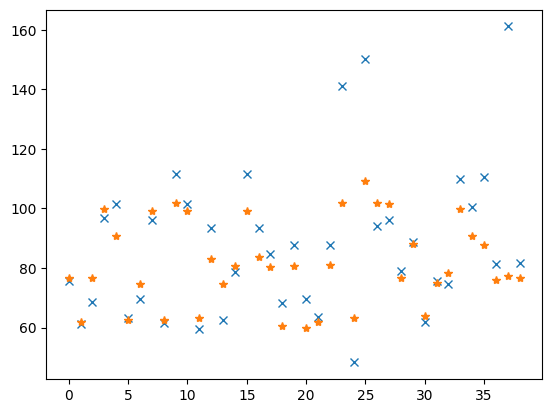

In [13]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

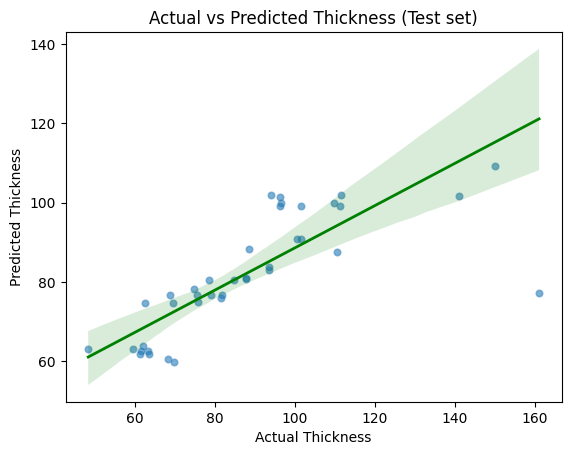

In [15]:
# Plotting the actual vs predicted values
sns.scatterplot(x=y_test.values, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

In [14]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,76.552941
1,61.300000,61.800000
2,68.700000,76.552941
3,96.633333,99.929825
4,101.466667,90.739247
5,63.166667,62.563889
6,69.433333,74.566667
7,96.266667,99.043478
8,61.466667,62.563889
9,111.533333,101.920175


In [16]:
mse = np.mean((y_pred - y_test)**2)
mse

320.36558808329664

In [25]:
# 테스트 세트에서의 RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

15.026786421543486

# 🎯 모델 2

In [17]:
tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

                                                                             
Generation 1 - Current best internal CV score: -144.30141925212334
                                                                              
Generation 2 - Current best internal CV score: -142.6334496415646
                                                                              
Generation 3 - Current best internal CV score: -142.6334496415646
                                                                              
Generation 4 - Current best internal CV score: -128.0486214950883
                                                                              
Generation 5 - Current best internal CV score: -128.0486214950883
                                                                              
Best pipeline: AdaBoostRegressor(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), learning_rate=0.01, loss=square, n_estimators=100)


In [18]:
y_pred = tpot.predict(X_test)
y_pred

array([ 73.84      ,  62.55238095,  73.84      ,  92.55350877,
        91.56666667,  62.55238095,  73.51111111,  92.00357143,
        62.55555555,  93.03166666,  92.08062015,  62.55238095,
        89.7858156 ,  72.75438596,  81.54833333,  92.08062015,
        90.27666666,  81.99855072,  61.27777778,  89.15396825,
        59.78333334,  62.55238095,  88.69466667, 118.51025642,
        61.01481482,  73.65      ,  93.03166666,  92.4620155 ,
        73.84      ,  90.37380952,  62.83333333,  73.96111111,
        78.6372549 ,  92.55350877,  91.35581395,  91.09084967,
        73.84      , 153.3       ,  73.96458333])

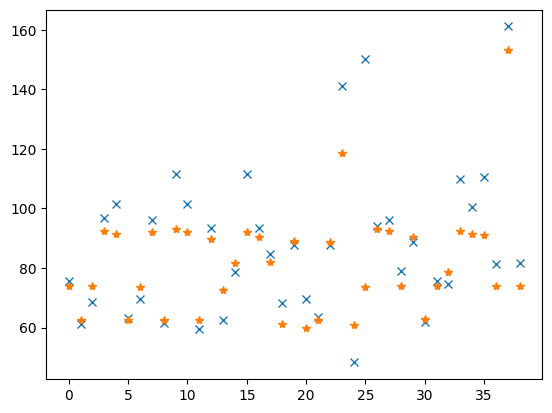

In [19]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [20]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,73.840000
1,61.300000,62.552381
2,68.700000,73.840000
3,96.633333,92.553509
4,101.466667,91.566667
5,63.166667,62.552381
6,69.433333,73.511111
7,96.266667,92.003571
8,61.466667,62.555556
9,111.533333,93.031667


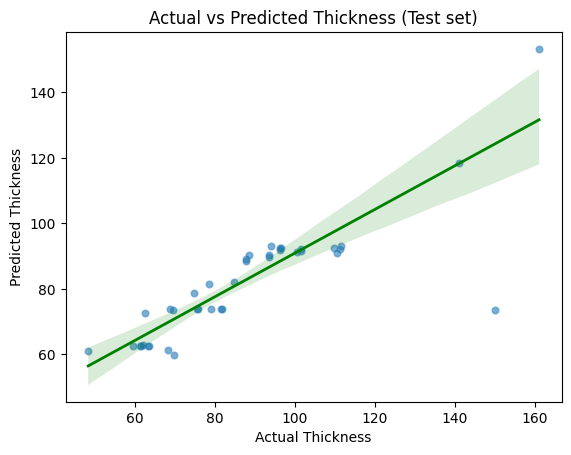

In [21]:
# Plotting the actual vs predicted values
sns.scatterplot(x=y_test.values, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

In [22]:
mse = np.mean((y_test.values - y_pred)**2)
mse


225.80431015868368

In [26]:
# 테스트 세트에서의 RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

15.026786421543486